# AI Computer Assignment - 5 - Phase 1

# MLP

### Mohammad Sadegh Aboofazeli
### SID: 810199328

# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

In [9]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

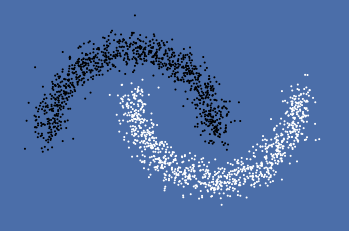

In [2]:
# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [4]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [5]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        self.relu_x = self.relu(x)
        return self.relu_x
        # raise NotImplementedError()
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        # YOUR CODE HERE
        gradient = np.where(self.relu_x > 0, 1, 0)
        return grad_output * gradient
        # raise NotImplementedError()
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        # YOUR CODE HERE
        pass
        # raise NotImplementedError()
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

class MySigmoid(object):
    def __init__(self):
        self.input = None
    
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        # YOUR CODE HERE
        self.x = x
        self.sigmoid_x = self.sigmoid(x)
        return self.sigmoid_x
        # raise NotImplementedError()
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        # YOUR CODE HERE
        return grad_output * self.sigmoid_x * (1 - self.sigmoid_x)
        # raise NotImplementedError()
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        # YOUR CODE HERE
        pass
        # raise NotImplementedError()
    
    @staticmethod
    def sigmoid(x):
        return 1. / (1. + np.exp(-x))

Probably a good time to test your functions...

In [6]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [7]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [8]:
test_sig = MySigmoid()
test_sig.forward(np.ones(1))

array([0.73105858])

In [9]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [10]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        # YOUR CODE HERE
        self.input_size = n_input
        self.output_size = n_output
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)
        # raise NotImplementedError()
    
    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        # YOUR CODE HERE
        self.x = x.copy()
        self.linear_x = np.dot(x, self.W) + self.b
        return self.linear_x
        # raise NotImplementedError()
    
    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        # YOUR CODE HERE
        dC_dW = np.outer(self.x, grad_output)
        self.dW = dC_dW
        # raise NotImplementedError()
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        # YOUR CODE HERE
        dC_db = grad_output
        self.db = dC_db
        # raise NotImplementedError()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        # YOUR CODE HERE
        dC_dx = np.dot(grad_output, self.W.T)
        return dC_dx
        # raise NotImplementedError()
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        # YOUR CODE HERE
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db
        # raise NotImplementedError()

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [11]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        # YOUR CODE HERE
        self.layers = []
        
        self.layers.append(MyLinear(2, 64))
        self.layers.append(MyReLU())
        
        self.layers.append(MyLinear(64, 1))
        self.layers.append(MySigmoid())
        #raise NotImplementedError()
        
    def forward(self, x):
        # YOUR CODE HERE
        for layer in self.layers:
            x = layer.forward(x)
        
        return x
        #raise NotImplementedError()
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        epsilon = 1e-10
        
        loss = (-label) * np.log(out + epsilon) - (1 - label) * np.log(1 - out + epsilon)
        
        self.gradient = (-label) / (out + epsilon) + (1 - label) / (1 - out + epsilon)

        return loss
        # raise NotImplementedError()

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # YOUR CODE HERE
        grad = self.gradient
        
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        
        return grad
        # raise NotImplementedError()
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        # YOUR CODE HERE
        for layer in self.layers:
            layer.step(learning_rate)
        # raise NotImplementedError()

In [12]:
# define your network with your Sequential Class
# YOUR CODE HERE
network = Sequential()
# raise NotImplementedError()

In [13]:
losses = []
learning_rate = 1e-1
epochs = 20

for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        # YOUR CODE HERE
        idx = np.random.randint(len(X)-1)
        # select the corresponding example and label
        # YOUR CODE HERE
        example = X[idx]
        label = Y[idx]
        # do a forward pass on the example
        # YOUR CODE HERE
        out = network.forward(example)
        # raise NotImplementedError()
        
        # compute the loss according to your output and the label
        # YOUR CODE HERE
        loss = network.compute_loss(out, label)
        losses.append(loss)
        # raise NotImplementedError()
        
        # backward pass
        # YOUR CODE HERE
        network.backward()
        # raise NotImplementedError()
        
        # gradient step
        # YOUR CODE HERE
        network.step(learning_rate)
        # raise NotImplementedError()

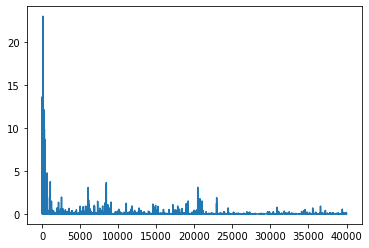

In [14]:
%matplotlib inline
plt.plot(losses)
plt.show()

NameError: name 'x_min' is not defined

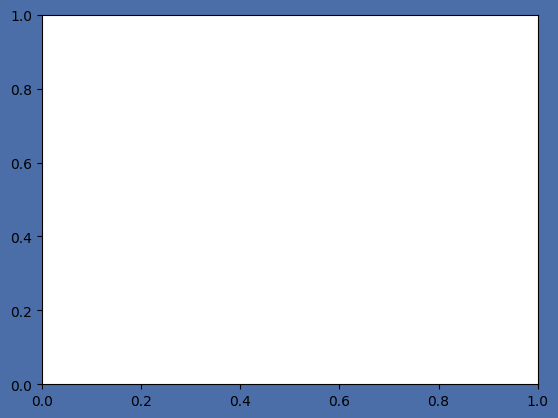

In [10]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [11]:
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

### Loading data

first we load the data using ```read_csv()``` function

In [12]:
df = pd.read_csv('./AI/CA/5-Part1/imdb_dataset.csv')

pd.options.display.max_colwidth = 50

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Let's have a brief look at the data contents and features:

In [13]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### A random positive and negative review

In [15]:
pos = df.loc[df['sentiment'] == 'positive']
neg = df.loc[df['sentiment'] == 'negative']

pd.options.display.max_colwidth = 10000000

print("A positive review:\n")
print(pos.sample().review[:])

print("\n=====================================================================\n")

print("A negative review:\n")
print(neg.sample().review[:])

A positive review:

3809    back in my high school days in Salina Kansas, they filmed something called "The Brave Young Men Of Weinberg" locally, and the film crews were rather prominent for weeks. eventually, we learned that the film was "Up The Academy", and was a bit ummm, "lower brow" than we had been led to believe. <br /><br />I had to see it, since I was there, and the local audiences seemed less than pleased at the showing. I was 17, and thought it was a rather artless attempt at a post "Animal house" type of comedy, right down to the fart jokes. <br /><br />Watched it many times since, and my opinion has mellowed a bit. it's dumb, but at times it catches a bit of the "mad" magazine humor, at least as well as most "Mad TV". Ron Liebman might hate it, but he is nearly perfect, and unforgettable. For me, my favorite moment would have been a brief scene on Santa Fe avenue, where I had parked my car, while I was buying some guitar strings. Too bad my Pinto's brief appearance, usual

# +
In positive review we can see following words and phrases that explain the positivity of review:

- I liked

- it was a good dance film

- it was a good film

- rating 9/10

# -

And for negative review meaningful words and phrases are:

- worst movie I have seen

- This movie is so bad

- destroyed

We have to label encode the ```sentiment``` column:

In [16]:
le = LabelEncoder()

df['sentiment'] = le.fit_transform(df['sentiment'])

pd.options.display.max_colwidth = 50

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


We remove the HTML phrases from reviews because they are meaningless.

In [17]:
df['review'] = df['review'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Then we remove white spaces using ```RegexpTokenizer()``` and parse reviews to tokens.

In [18]:
tokenizer = RegexpTokenizer(r'\w+')

df['tokens'] = df['review'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Replacing Words With Their Roots

We replace the words with their roots. We can do this in 2 ways:

#### 1. Lemmatization

Lemmatization is the process of reducing a word to its base or dictionary form, which is known as the lemma. The goal of lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. This can help to reduce the dimensionality of text data and improve the accuracy of text analysis.

we use ```WordNetLemmatizer()``` for Lemmatization.

#### 2. Stemming

Stemming is another process of reducing a word to its base or root form, which is known as the stem. The goal of stemming is to reduce inflectional forms and sometimes deriv related forms of a word to a common base form. This can help to reduce the dimensionality of text data and improve the accuracy of text analysis.

we use ```PorterStemmer()``` for Stemming.


### Lemmatization vs Stemming

Lemmatization is similar to stemming. However, stemming simply removes the suffix of a word to create a root form, while lemmatization uses a more sophisticated approach that takes into account the part of speech of the word and its context in the sentence.

Stemming is a simpler and faster technique than lemmatization, but it may not always produce a valid word.

For example, the word "better" can be stemmed to "bett", but its lemma is "good". By taking into account the part of speech and context, lemmatization can produce more accurate results than stemming.

In summary, if you need a fast and simple technique to reduce words to their basic form for text analysis, stemming is a good choice. If you need a more accurate technique that takes into account the meaning of words, lemmatization is a better choice.

In [19]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

df['lemmatized_tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
df['stemmed_tokens'] = df['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

Now we remove the stop words:

In [20]:
stop_words = set(stopwords.words('english'))

df['lemmatized_tokens'] = df['lemmatized_tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['stemmed_tokens'] = df['stemmed_tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

It's time to transform tokens to string reviews:

In [21]:
df['lemmatized_review'] = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))
df['stemmed_review'] = df['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))
df['review'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

We form our DataFrames again:

In [22]:
df_lemmatized = df[['lemmatized_review', 'sentiment']]
df_stemmed = df[['stemmed_review', 'sentiment']]
df_stemmed_copy = df_stemmed.copy()
df = df[['review', 'sentiment']]

In [23]:
target = df.sentiment

### TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that is used to reflect how important a word is to a document in a collection or corpus. The TF-IDF score is calculated by multiplying the term frequency (TF) of a word in a document by the inverse document frequency (IDF) of the word across a collection of documents.


TF-IDF is commonly used in information retrieval and text mining to rank the relevance of documents to a given query. It is also used in machine learning for feature extraction and text classification tasks.


In this project we use ```TfidfVectorizer()``` function to transform our reviews to a dataset with multiple features which every feature represent a unique word in the corpus.

We apply this function in multiple ways to get different datasets.

#### Raw Words Data - Unigrams and Bigrams (3.5k Features)

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3500)

X = vectorizer.fit_transform(df.review)

dense_matrix = X.toarray()

df = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df['sentiment_'] = target

#### Lemmatized Words Data - Unigrams and Bigrams (3.5k Features)

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3500)

X = vectorizer.fit_transform(df_lemmatized.lemmatized_review)

dense_matrix = X.toarray()

df_lemmatized = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_lemmatized['sentiment_'] = target

#### Stemmed Words Data - Unigrams and Bigrams (3.5k Features)

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3500)

X = vectorizer.fit_transform(df_stemmed.stemmed_review)

dense_matrix = X.toarray()

df_stemmed = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_stemmed['sentiment_'] = target

KeyboardInterrupt: 

#### Stemmed Words Data - Unigrams and Bigrams (6k Features)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=6000)

X = vectorizer.fit_transform(df_stemmed_copy.stemmed_review)

dense_matrix = X.toarray()

df_stemmed_6k = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_stemmed_6k['sentiment_'] = target

#### Stemmed Words Data - Only Unigrams (3.5k Features)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=3500)

X = vectorizer.fit_transform(df_stemmed_copy.stemmed_review)

dense_matrix = X.toarray()

df_stemmed_single_word = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_stemmed_single_word['sentiment_'] = target

### Feature Values Must Be Between 0 and 1

The value of our features must be between 0 and 1, so we check our data.

If the values of the features are not between 0 and 1, or if they are not standardized to a common scale, it can lead to inaccurate results in sentiment analysis. For example, if one feature has values ranging from 0 to 100, and another feature has values ranging from 0 to 1, the algorithm may give more weight to the first feature, even if it is less important for sentiment analysis.

To avoid this problem, it is common to normalize or standardize the input features before using them in a machine learning algorithm. Normalization involves scaling the values of the features to a range between 0 and 1, while standardization involves scaling the values of the features to have a mean of 0 and a standard deviation of 1.

The output of ```TfidfVectorizer()``` have features with valuse between 0 and 1. So we don't have to worry.

In [ ]:
summary = df.describe()

all_features_between_0_and_1 = (summary.loc['min'] >= 0).all() and (summary.loc['max'] <= 1).all()

if all_features_between_0_and_1:
    print('All features are between 0 and 1')
else:
    print('Not all features are between 0 and 1')

### Train and Test

we split our data to train set and test set.

$80$% for Train and $20$% for Test.

In [ ]:
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.2

border = int(len(df) * TRAIN_PERCENTAGE)

# shuffling the data

df = shuffle(df, random_state=0)
df_lemmatized = shuffle(df_lemmatized, random_state=0)
df_stemmed = shuffle(df_stemmed, random_state=0)
df_stemmed_6k = shuffle(df_stemmed_6k, random_state=0)
df_stemmed_single_word = shuffle(df_stemmed_single_word, random_state=0)

# picking train data and test data

train_df = df[:border]
test_df = df[border:]

train_df_lemmatized = df_lemmatized[:border]
test_df_lemmatized = df_lemmatized[border:]

train_df_stemmed = df_stemmed[:border]
test_df_stemmed = df_stemmed[border:]

train_df_stemmed_6k = df_stemmed_6k[:border]
test_df_stemmed_6k = df_stemmed_6k[border:]

train_df_stemmed_single_word = df_stemmed_single_word[:border]
test_df_stemmed_single_word = df_stemmed_single_word[border:]

In [ ]:
train_df.head()

### Distribution

We show the distribution of Train data:

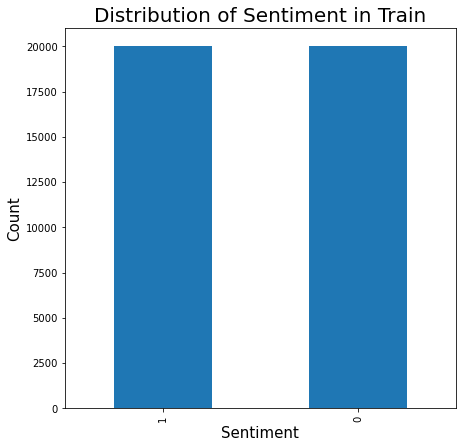

In [76]:
# distribution in train dataset

counts = train_df['sentiment_'].value_counts()

counts.plot.bar(figsize=(7, 7))

plt.title('Distribution of Sentiment in Train', fontsize=20)
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

And distribution of Test data:

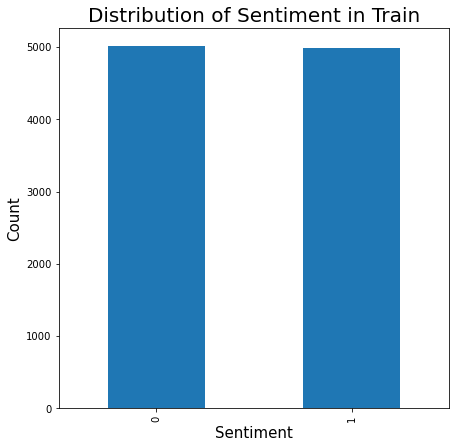

In [77]:
# distribution in test dataset

counts = test_df['sentiment_'].value_counts()

counts.plot.bar(figsize=(7, 7))

plt.title('Distribution of Sentiment in Train', fontsize=20)
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

## 3.2. MLP in torch

In [78]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader

In [79]:
# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        self.A = nn.Parameter(torch.randn(n_input, n_output))
        self.b = nn.Parameter(torch.randn(n_output))
    
    def forward(self, x):
        # YOUR CODE HERE
        # compute the linear transformation
        lin = torch.matmul(x, self.A) + self.b
        return lin

class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
    
    def forward(self, x):
        # YOUR CODE HERE
        # apply the ReLU activation function
        relu = nn.functional.relu(x)
        return relu

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [80]:
# Define your dataloader here (specify your batch_size)
# Use:
# from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

batch_size = 64

X = train_df.drop('sentiment_', axis=1).values
y = train_df['sentiment_'].values

X_lemmatized = train_df_lemmatized.drop('sentiment_', axis=1).values
y_lemmatized = train_df_lemmatized['sentiment_'].values

X_stemmed = train_df_stemmed.drop('sentiment_', axis=1).values
y_stemmed = train_df_stemmed['sentiment_'].values

X_stemmed_6k = train_df_stemmed_6k.drop('sentiment_', axis=1).values
y_stemmed_6k = train_df_stemmed_6k['sentiment_'].values

X_stemmed_single_word = train_df_stemmed_single_word.drop('sentiment_', axis=1).values
y_stemmed_single_word = train_df_stemmed_single_word['sentiment_'].values

# Convert X and y to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_tensor_lemmatized = torch.tensor(X_lemmatized, dtype=torch.float32)
y_tensor_lemmatized = torch.tensor(y_lemmatized, dtype=torch.float32)

X_tensor_stemmed = torch.tensor(X_stemmed, dtype=torch.float32)
y_tensor_stemmed = torch.tensor(y_stemmed, dtype=torch.float32)

X_tensor_stemmed_6k = torch.tensor(X_stemmed_6k, dtype=torch.float32)
y_tensor_stemmed_6k = torch.tensor(y_stemmed_6k, dtype=torch.float32)

X_tensor_stemmed_single_word = torch.tensor(X_stemmed_single_word, dtype=torch.float32)
y_tensor_stemmed_single_word = torch.tensor(y_stemmed_single_word, dtype=torch.float32)

# Create a TensorDataset from X and y
dataset = TensorDataset(X_tensor, y_tensor)

dataset_lemmatized = TensorDataset(X_tensor_lemmatized, y_tensor_lemmatized)

dataset_stemmed = TensorDataset(X_tensor_stemmed, y_tensor_stemmed)

dataset_stemmed_6k = TensorDataset(X_tensor_stemmed_6k, y_tensor_stemmed_6k)

dataset_stemmed_single_word = TensorDataset(X_tensor_stemmed_single_word, y_tensor_stemmed_single_word)

# Create a DataLoader from the dataset
train_loader = DataLoader(dataset, batch_size=batch_size)

train_loader_lemmatized = DataLoader(dataset_lemmatized, batch_size=batch_size)

train_loader_stemmed = DataLoader(dataset_stemmed, batch_size=batch_size)

train_loader_stemmed_6k = DataLoader(dataset_stemmed_6k, batch_size=batch_size)

train_loader_stemmed_single_word = DataLoader(dataset_stemmed_single_word, batch_size=batch_size)

## Model

We write ```test_model()``` function to Define our network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

The function also gets `train_data`, `test_data`, `learnin_rate` and `epochs`. Then it runs the model.

Finaly it draws the diagram of losses and calculate ```classification_report```.

In [119]:
def test_model(lr, epochs, train_data, test_data):
    # We define a network with nn.Sequential
    yourTorchNetwork = nn.Sequential(
        MyLinear_mod(X.shape[1], 32),
        MyReLU_mod(),
        MyLinear_mod(32, 32),
        MyReLU_mod(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    
    optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=lr)
    
    losses = []
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            
            # data is a list of [inputs, labels]
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # A forward pass on the batch data
            outputs = yourTorchNetwork(inputs)
            # Computing the loss according to output and the label
            loss = criterion(outputs, labels.view(-1, 1))
            # Backward pass
            loss.backward()
            # Gradient step
            optimizer.step()
            
            # Calculate statistics
            running_loss += loss.item()
            if i % 500 == 499:    # every 500 mini-batches
                losses.append(running_loss / 500)
                running_loss = 0.0
    
    # Plotting the losses
    plt.plot(losses)
    plt.show()
    
    # Calculate and print the classification_report
    X_test = test_data.drop('sentiment_', axis=1).values
    y_test = test_data['sentiment_'].values
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_pred = yourTorchNetwork(X_test_tensor).detach().numpy().round()
    
    print(classification_report(y_test, y_test_pred))

## Testing

Now we test our model by some datasets with different Preprocessing.

### Raw Words

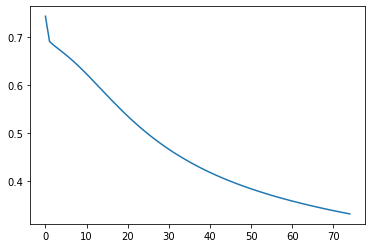

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5013
           1       0.83      0.85      0.84      4987

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [84]:
test_model(lr=0.1, epochs=75, train_data=train_loader, test_data=test_df)

### Lemmatized Words

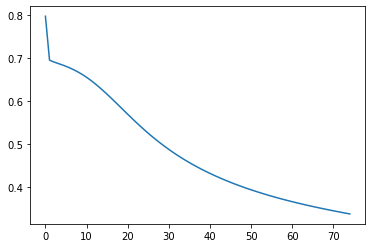

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      5013
           1       0.82      0.87      0.85      4987

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [85]:
test_model(lr=0.1, epochs=75, train_data=train_loader_lemmatized, test_data=test_df_lemmatized)

### Stemmed Words

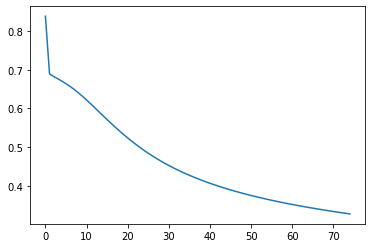

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      5013
           1       0.83      0.86      0.85      4987

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [87]:
test_model(lr=0.1, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

### Stemmed Words (Single Words)

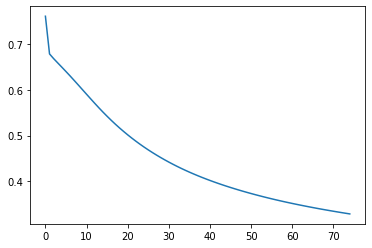

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      5013
           1       0.82      0.89      0.85      4987

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [90]:
test_model(lr=0.1, epochs=75, train_data=train_loader_stemmed_single_word, test_data=test_df_stemmed_single_word)

### Stemmed Words (6k Features)

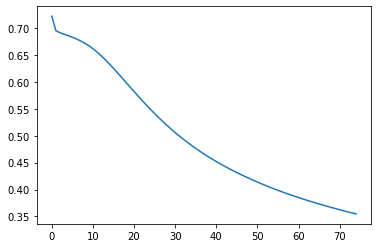

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      5013
           1       0.81      0.86      0.83      4987

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [93]:
# We define a network with nn.Sequential
yourTorchNetwork = nn.Sequential(
    MyLinear_mod(6000, 32),
    MyReLU_mod(),
    MyLinear_mod(32, 32),
    MyReLU_mod(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=0.1)

losses = []
criterion = nn.BCELoss()
epochs = 75

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_stemmed_6k, 0):

        # data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # A forward pass on the batch data
        outputs = yourTorchNetwork(inputs)
        # Computing the loss according to output and the label
        loss = criterion(outputs, labels.view(-1, 1))
        # Backward pass
        loss.backward()
        # Gradient step
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        if i % 500 == 499:    # every 100 mini-batches
            losses.append(running_loss / 500)
            running_loss = 0.0

# Plotting the losses
plt.plot(losses)
plt.show()

# Calculate and print the classification_report
X_test = test_df_stemmed_6k.drop('sentiment_', axis=1).values
y_test = test_df_stemmed_6k['sentiment_'].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_pred = yourTorchNetwork(X_test_tensor).detach().numpy().round()

print(classification_report(y_test, y_test_pred))

As you can see, datasets with Stemmed Words and Lemmatized Words have highest accuracy.

Our model have accuracy of around $85$% which is pretty good! 

## Network Weighting

#### What happens if all weights in a neural network are initialized to 0?

the network will not be able to learn anything during training. This is because all neurons in a layer will produce the same output, and the gradients for all weights will be the same. As a result, the weights will not be updated during backpropagation, and the network will not be able to learn any meaningful representations.

To avoid this problem, it is common practice to initialize the weights in a neural network with small random values. This helps to break the symmetry between neurons and allows the network to learn meaningful representations.

## Learning Rate

In machine learning, the learning rate is a hyperparameter that determines the step size at which the model is updated during training. It controls how much the weights of the model are adjusted with respect to the loss gradient.

The learning rate is a critical hyperparameter that can significantly affect the performance of the model. If the learning rate is too high, the model may overshoot the optimal weights and fail to converge. On the other hand, if the learning rate is too low, the model may take a long time to converge or get stuck in a suboptimal solution.

To find the optimal learning rate, it is common to use a learning rate schedule that gradually reduces the learning rate over time. This can help the model converge faster and avoid overshooting the optimal weights.

Here, we test our model with some different learning rates:

### Learning Rate = 0.01

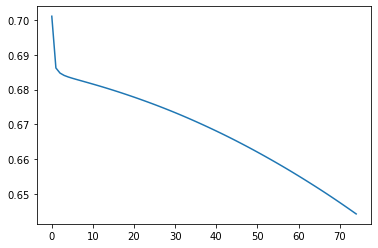

              precision    recall  f1-score   support

           0       0.67      0.50      0.57      5013
           1       0.60      0.75      0.67      4987

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.62     10000
weighted avg       0.64      0.63      0.62     10000



In [355]:
test_model(lr=0.01, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

### Learning Rate = 0.1

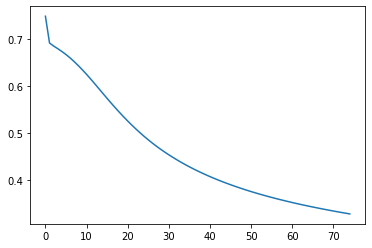

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5013
           1       0.82      0.88      0.85      4987

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [356]:
test_model(lr=0.1, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

### Learning Rate = 0.6

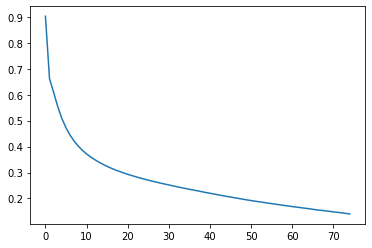

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5013
           1       0.84      0.89      0.87      4987

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [362]:
test_model(lr=0.6, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

### Learning Rate = 1

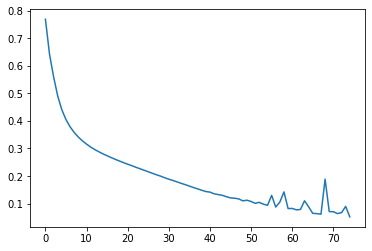

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5013
           1       0.83      0.89      0.86      4987

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [358]:
test_model(lr=1, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

As we can see, our model have the highest accuracy with learning rate of between 0.1 to 1. So we continue with these learning rates in next parts.

## Activation Functions


An activation function is a mathematical function that is applied to the output of a neuron in a neural network. The purpose of an activation function is to introduce non-linearity into the output of the neuron, which allows the neural network to learn more complex patterns in the data.

In a neural network, each neuron receives input from the previous layer of neurons, performs a weighted sum of the inputs, and then applies an activation function to the result. The output of the activation function is then passed on to the next layer of neurons.

Now we test our model with different activation functions in its hidden layers:





### Sigmoid

The sigmoid function maps any input value to a value between 0 and 1. It is often used in binary classification problems.

$$Sigmoid(x) = \frac{1}{1 + e^{-x}}$$

[1,   500] loss: 3.612
[2,   500] loss: 3.248
[3,   500] loss: 2.956
[4,   500] loss: 2.681
[5,   500] loss: 2.454
[6,   500] loss: 2.276
[7,   500] loss: 2.137
[8,   500] loss: 2.025
[9,   500] loss: 1.934
[10,   500] loss: 1.858
[11,   500] loss: 1.793
[12,   500] loss: 1.738
[13,   500] loss: 1.689
[14,   500] loss: 1.646
[15,   500] loss: 1.608
[16,   500] loss: 1.574
[17,   500] loss: 1.543
[18,   500] loss: 1.515
[19,   500] loss: 1.489
[20,   500] loss: 1.465
[21,   500] loss: 1.443
[22,   500] loss: 1.423
[23,   500] loss: 1.404
[24,   500] loss: 1.386
[25,   500] loss: 1.369
[26,   500] loss: 1.354
[27,   500] loss: 1.339
[28,   500] loss: 1.324
[29,   500] loss: 1.311
[30,   500] loss: 1.298
[31,   500] loss: 1.286
[32,   500] loss: 1.274
[33,   500] loss: 1.263
[34,   500] loss: 1.253
[35,   500] loss: 1.242
[36,   500] loss: 1.232
[37,   500] loss: 1.223
[38,   500] loss: 1.214
[39,   500] loss: 1.205
[40,   500] loss: 1.196
[41,   500] loss: 1.188
[42,   500] loss: 1.180
[

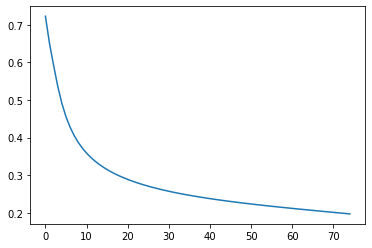

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5013
           1       0.86      0.90      0.88      4987

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [111]:
# We define a network with nn.Sequential
yourTorchNetwork = nn.Sequential(
    MyLinear_mod(3500, 32),
    nn.Sigmoid(),
    MyLinear_mod(32, 32),
    nn.Sigmoid(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=0.6)

losses = []
criterion = nn.BCELoss()
epochs = 75

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_stemmed, 0):

        # data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # A forward pass on the batch data
        outputs = yourTorchNetwork(inputs)
        # Computing the loss according to output and the label
        loss = criterion(outputs, labels.view(-1, 1))
        # Backward pass
        loss.backward()
        # Gradient step
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        if i % 500 == 499:    # every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            losses.append(running_loss / 500)
            running_loss = 0.0

# Plotting the losses
plt.plot(losses)
plt.show()

# Calculate and print the classification_report
X_test = test_df_stemmed.drop('sentiment_', axis=1).values
y_test = test_df_stemmed['sentiment_'].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_pred = yourTorchNetwork(X_test_tensor).detach().numpy().round()

print(classification_report(y_test, y_test_pred))

### Hyperbolic Tangent (Tanh)

The tanh function maps any input value to a value between -1 and 1. It is often used in recurrent neural networks.

$$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

[1,   500] loss: 3.515
[2,   500] loss: 3.278
[3,   500] loss: 2.997
[4,   500] loss: 2.720
[5,   500] loss: 2.491
[6,   500] loss: 2.308
[7,   500] loss: 2.161
[8,   500] loss: 2.042
[9,   500] loss: 1.943
[10,   500] loss: 1.858
[11,   500] loss: 1.785
[12,   500] loss: 1.721
[13,   500] loss: 1.664
[14,   500] loss: 1.612
[15,   500] loss: 1.564
[16,   500] loss: 1.520
[17,   500] loss: 1.478
[18,   500] loss: 1.439
[19,   500] loss: 1.402
[20,   500] loss: 1.366
[21,   500] loss: 1.331
[22,   500] loss: 1.296
[23,   500] loss: 1.263
[24,   500] loss: 1.230
[25,   500] loss: 1.197
[26,   500] loss: 1.164
[27,   500] loss: 1.131
[28,   500] loss: 1.097
[29,   500] loss: 1.063
[30,   500] loss: 1.028
[31,   500] loss: 0.992
[32,   500] loss: 0.955
[33,   500] loss: 0.917
[34,   500] loss: 0.878
[35,   500] loss: 0.838
[36,   500] loss: 0.796
[37,   500] loss: 0.753
[38,   500] loss: 0.709
[39,   500] loss: 0.664
[40,   500] loss: 0.619
[41,   500] loss: 0.574
[42,   500] loss: 0.530
[

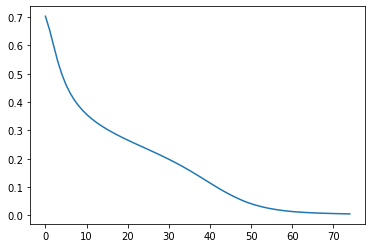

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5013
           1       0.83      0.82      0.83      4987

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [110]:
# We define a network with nn.Sequential
yourTorchNetwork = nn.Sequential(
    MyLinear_mod(3500, 32),
    nn.Tanh(),
    MyLinear_mod(32, 32),
    nn.Tanh(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=0.6)

losses = []
criterion = nn.BCELoss()
epochs = 75

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_stemmed, 0):
        
        # data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # A forward pass on the batch data
        outputs = yourTorchNetwork(inputs)
        # Computing the loss according to output and the label
        loss = criterion(outputs, labels.view(-1, 1))
        # Backward pass
        loss.backward()
        # Gradient step
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        if i % 500 == 499:    # every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            losses.append(running_loss / 500)
            running_loss = 0.0

# Plotting the losses
plt.plot(losses)
plt.show()

# Calculate and print the classification_report
X_test = test_df_stemmed.drop('sentiment_', axis=1).values
y_test = test_df_stemmed['sentiment_'].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_pred = yourTorchNetwork(X_test_tensor).detach().numpy().round()

print(classification_report(y_test, y_test_pred))

### Leaky ReLU

The Leaky ReLU function is similar to ReLU, but sets negative input values to a small non-zero value instead of zero. This can help to prevent the "dying ReLU" problem.

$$Leaky\ ReLU(x) = \begin{cases} x, & \text{if } x \gt 0 \\ ax, & \text{otherwise} \end{cases}
$$

or

$$f(x) = max(ax, x)
$$


where `x` is the input to the Leaky ReLU function, and `a` is a small constant (usually 0.01 or 0.001) that determines the slope of the function for negative input values. This formula sets negative input values to a small non-zero value `(ax)`, while passing through any positive input values unchanged `(x)`.

[1,   500] loss: 6.789
[2,   500] loss: 3.410
[3,   500] loss: 3.281
[4,   500] loss: 3.064
[5,   500] loss: 2.817
[6,   500] loss: 2.574
[7,   500] loss: 2.370
[8,   500] loss: 2.207
[9,   500] loss: 2.079
[10,   500] loss: 1.977
[11,   500] loss: 1.892
[12,   500] loss: 1.822
[13,   500] loss: 1.760
[14,   500] loss: 1.707
[15,   500] loss: 1.660
[16,   500] loss: 1.619
[17,   500] loss: 1.580
[18,   500] loss: 1.546
[19,   500] loss: 1.514
[20,   500] loss: 1.484
[21,   500] loss: 1.457
[22,   500] loss: 1.431
[23,   500] loss: 1.407
[24,   500] loss: 1.384
[25,   500] loss: 1.363
[26,   500] loss: 1.342
[27,   500] loss: 1.322
[28,   500] loss: 1.303
[29,   500] loss: 1.284
[30,   500] loss: 1.266
[31,   500] loss: 1.249
[32,   500] loss: 1.232
[33,   500] loss: 1.215
[34,   500] loss: 1.199
[35,   500] loss: 1.184
[36,   500] loss: 1.169
[37,   500] loss: 1.153
[38,   500] loss: 1.138
[39,   500] loss: 1.124
[40,   500] loss: 1.109
[41,   500] loss: 1.095
[42,   500] loss: 1.081
[

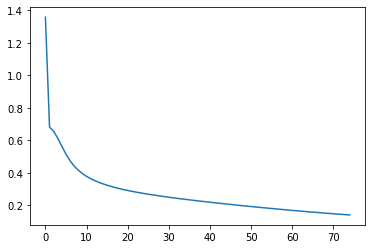

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      5013
           1       0.85      0.90      0.87      4987

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [109]:
# We define a network with nn.Sequential
yourTorchNetwork = nn.Sequential(
    MyLinear_mod(3500, 32),
    nn.LeakyReLU(),
    MyLinear_mod(32, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=0.6)

losses = []
criterion = nn.BCELoss()
epochs = 75

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_stemmed, 0):

        # data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # A forward pass on the batch data
        outputs = yourTorchNetwork(inputs)
        # Computing the loss according to output and the label
        loss = criterion(outputs, labels.view(-1, 1))
        # Backward pass
        loss.backward()
        # Gradient step
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        if i % 500 == 499:    # every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            losses.append(running_loss / 500)
            running_loss = 0.0

# Plotting the losses
plt.plot(losses)
plt.show()

# Calculate and print the classification_report
X_test = test_df_stemmed.drop('sentiment_', axis=1).values
y_test = test_df_stemmed['sentiment_'].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_pred = yourTorchNetwork(X_test_tensor).detach().numpy().round()

print(classification_report(y_test, y_test_pred))

As you can see, ``Leaky ReLU`` and ``Sigmoid`` have better accuracy than ``Tanh``.

#### Why Sigmoid and Tanh are not good choices for hidden layers?

Sigmoid and Tanh activation functions were popular choices for hidden layers in the past, but they have some drawbacks that make them less suitable for deep neural networks.

Here is some of their drawbacks:

1. ```Vanishing Gradient Problem```

One of the main problems with sigmoid and Tanh activation functions is that they suffer from the vanishing gradient problem. This means that the gradients of the activation function become very small as the input to the function becomes very large or very small. This can make it difficult for the network to learn, especially in deep networks with many layers. The vanishing gradient problem can also slow down the training process and make it more difficult to converge to a good solution.

2. ```they are not zero-centered```

Another problem with sigmoid and Tanh activation functions is that they are not zero-centered. This means that the output of the activation function is always positive, which can make it difficult for the network to learn if the input data has a mean of zero. This can lead to slower convergence and suboptimal solutions.

#### What function Should we use for hidden layers?

ReLU (Rectified Linear Unit) activation function is a popular choice for hidden layers in deep neural networks because it overcomes the vanishing gradient problem and is zero-centered. ReLU is a simple function that returns the input if it is positive, and zero otherwise. This makes it easy to compute and efficient to train. ReLU has been shown to work well in practice and is widely used in deep learning.

In summary, sigmoid and Tanh activation functions are not good choices for hidden layers in deep neural networks because they suffer from the vanishing gradient problem and are not zero-centered. ReLU activation function is a better choice because it overcomes these problems and is efficient to compute and train.

##  Leaky ReLU vs ReLU

ReLU (Rectified Linear Unit) and Leaky ReLU are both activation functions used in neural networks. The main difference between them is that ReLU sets all negative values to zero, while Leaky ReLU sets negative values to a small non-zero value.

The ReLU activation function is defined as:

$$
f(x) = max(0, x)
$$

This means that any input value less than zero is set to zero, while any input value greater than or equal to zero is passed through unchanged.

The Leaky ReLU activation function is defined as:

$$
f(x) = max(ax, x)
$$

where `a` is a small constant (usually 0.01 or 0.001). This means that any input value less than zero is multiplied by `a`, while any input value greater than or equal to zero is passed through unchanged.

#### Benefit of Leaky ReLU

The main benefit of Leaky ReLU over ReLU is that it helps to prevent the "dying ReLU" problem. The dying ReLU problem occurs when a large number of neurons in a network become inactive (i.e., output zero) and never recover. This can happen if the weights of the neurons are initialized in such a way that they always output negative values, causing the ReLU function to output zero. By using Leaky ReLU, even these "dead" neurons can still output small non-zero values, which can help to prevent the problem.

Another benefit of Leaky ReLU is that it can help to improve the performance of deep neural networks. Deep networks can suffer from the vanishing gradient problem, where the gradients of the loss function with respect to the weights become very small as they propagate through the network. This can make it difficult to train the network effectively. By using Leaky ReLU, the gradients can still flow through the network even if some of the neurons output negative values, which can help to mitigate the problem.

#### Summary

In summary, the main differences between ReLU and Leaky ReLU are that Leaky ReLU sets negative values to a small non-zero value, while ReLU sets negative values to zero. The main benefit of Leaky ReLU is that it can help to prevent the dying ReLU problem and improve the performance of deep neural networks.

## Batch

In machine learning, a batch is a subset of the training data that is used to train a model at one time. The batch size is the number of samples in each batch.

When training a neural network, it is often not feasible to train the model on the entire dataset at once, especially if the dataset is very large. Instead, the dataset is divided into smaller batches, and the model is trained on each batch in turn. This process is known as batch training.

### Batch Size

The batch size is an important hyperparameter that can affect the performance of the model.

```Large Batch Size```

A larger batch size can lead to faster training times, but it can also lead to overfitting and poor generalization performance. 

```Small Batch Size```

A smaller batch size can lead to slower training times, but it can also lead to better generalization performance.

In general, the batch size should be chosen based on the available computational resources and the size of the dataset. A common batch size is 32 or 64, but larger or smaller batch sizes may be appropriate depending on the specific problem.

#### Summary

A batch is a subset of the training data that is used to train a model at one time, and the batch size is the number of samples in each batch. The batch size is an important hyperparameter that can affect the performance of the model, and it should be chosen based on the available computational resources and the size of the dataset.

Now, we test our model with some different batch_size:

### batch size = 16

In [112]:
batch_size = 16

X_stemmed = train_df_stemmed.drop('sentiment_', axis=1).values
y_stemmed = train_df_stemmed['sentiment_'].values

# Convert X and y to torch tensors

X_tensor_stemmed = torch.tensor(X_stemmed, dtype=torch.float32)
y_tensor_stemmed = torch.tensor(y_stemmed, dtype=torch.float32)

# Create a TensorDataset from X and y

dataset_stemmed = TensorDataset(X_tensor_stemmed, y_tensor_stemmed)

# Create a DataLoader from the dataset

train_loader_stemmed = DataLoader(dataset_stemmed, batch_size=batch_size)

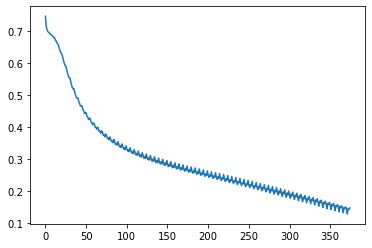

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5013
           1       0.85      0.87      0.86      4987

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [113]:
test_model(lr=0.1, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

### batch size = 256

In [114]:
batch_size = 256

X_stemmed = train_df_stemmed.drop('sentiment_', axis=1).values
y_stemmed = train_df_stemmed['sentiment_'].values

# Convert X and y to torch tensors

X_tensor_stemmed = torch.tensor(X_stemmed, dtype=torch.float32)
y_tensor_stemmed = torch.tensor(y_stemmed, dtype=torch.float32)

# Create a TensorDataset from X and y

dataset_stemmed = TensorDataset(X_tensor_stemmed, y_tensor_stemmed)

# Create a DataLoader from the dataset

train_loader_stemmed = DataLoader(dataset_stemmed, batch_size=batch_size)

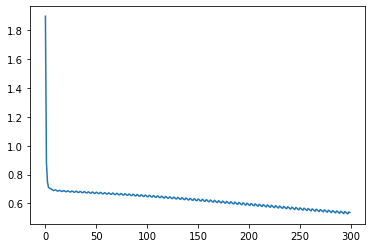

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      5013
           1       0.72      0.74      0.73      4987

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



In [117]:
test_model(lr=0.1, epochs=75, train_data=train_loader_stemmed, test_data=test_df_stemmed)

The result is more accurate when batch_size = 16, but model works slower. On the other hand, when batch_size = 16, the model works faster and in exchange for speedup, its accuracy decreases.